# Transformer + vision rollout



##Programmation


####Chargement du dataset
https://www.tensorflow.org/tutorials/load_data/images?hl=fr

In [ ]:
#Librairies
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import pathlib
import keras

In [ ]:
#Connexion au dossier drive contenant les images
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Chemin vers le dataset préalablement chargé dans le drive
data_dir="/content/drive/MyDrive/Projet_IA_Imagerie/dataset/"
dir_train= "/content/drive/MyDrive/Projet_IA_Imagerie/dataset/Training/"
dir_test = "/content/drive/MyDrive/Projet_IA_Imagerie/dataset/Testing/"

data_dir=pathlib.Path(data_dir)
dir_train= pathlib.Path(dir_train)
dir_test = pathlib.Path(dir_test)

In [ ]:
#On importe deux des classes dans des listes : glioma_tumor et no_tumor cad prb vs pas de prb
glioma_tumor_train = list(dir_train.glob('glioma_tumor/*'))
glioma_tumor_test = list(dir_test.glob('glioma_tumor/*'))
no_tumor_train = list(dir_train.glob('glioma_tumor/*'))
no_tumor_test = list(dir_test.glob('glioma_tumor/*'))
#PIL.Image.open(str(glioma_tumor_train[0]))


 Standardisation des données:

 Les valeurs des canaux RVB sont dans la plage [0, 255] . Ce n'est pas idéal pour un réseau neuronal ; en général, vous devriez chercher à rendre vos valeurs d'entrée petites.

Ici, vous allez normaliser les valeurs pour qu'elles soient dans la plage [0, 1] en utilisant tf.keras.layers.Rescaling :

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
#A METTRE DANS LE MODEL VIT !!!!!

#Model VIT

#### Transformer vision rollout
https://keras.io/examples/vision/probing_vits/

In [ ]:
#ViT = vision Transformer
!pip install -U gdown -q.



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -.


In [ ]:
import zipfile
from io import BytesIO

import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [ ]:
RESOLUTION = 224
PATCH_SIZE = 16

####Preprocess

In [ ]:
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = normalization_layer
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)

def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)

    # Resize the image using bicubic interpolation.
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # Crop the image.
    image = crop_layer(image)

    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)

    return image.numpy()


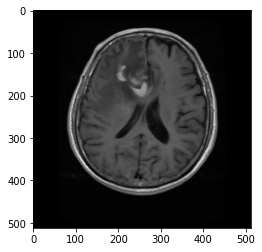

In [ ]:
pic=PIL.Image.open(str(glioma_tumor_train[2]))
plt.imshow(pic)

In [ ]:
preprocessed_image = preprocess_image(pic, "original_vit")

####Get model

In [ ]:

def get_model(model_name: str) -> tf.keras.Model:
   # inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
   # outputs = model(inputs)
    #print(outputs.shape)
    return model
vit_base_i21k_patch16_224 = get_model("/content/drive/MyDrive/Projet_IA_Imagerie/model/vit_b16_patch16_224 (1)")
#vit_base_i21k_patch16_224 = get_model("/content/vit_b16_patch16_224")
print(vit_base_i21k_patch16_224.summary())
print("Model loaded.")



Model: "vi_t_classifier_extended"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projection (Sequential)     (None, 196, 768)          590592    
                                                                 
 transformer_block_0 (Functi  [(None, 197, 768),       7087872   
 onal)                        (None, 12, None, None)]            
                                                                 
 transformer_block_1 (Functi  [(None, 197, 768),       7087872   
 onal)                        (None, 12, None, None)]            
                                                                 
 transformer_block_2 (Functi  [(None, 197, 768),       7087872   
 onal)                        (None, 12, None, None)]            
                                                                 
 transformer_block_3 (Functi  [(None, 197, 768),       7087872   
 onal)                        (None, 12, N

In [ ]:
#vit_base_i21k_patch16_224 = get_model('1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ')
#print("Model loaded.")

In [ ]:
attention_score_dict = vit_base_i21k_patch16_224.predict(
    preprocessed_image
)

1/1 [==============================] - 3s 3s/step


In [ ]:
predictions, attention_score_dict = vit_base_i21k_patch16_224.predict(
    preprocessed_image
)

1/1 [==============================] - 1s 724ms/step


In [ ]:
def attention_rollout_map(image, attention_score_dict, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # Stack the individual attention matrices from individual Transformer blocks.
    attn_mat = tf.stack([attention_score_dict[k] for k in attention_score_dict.keys()])
    attn_mat = tf.squeeze(attn_mat, axis=1)

    # Average the attention weights across all heads.
    attn_mat = tf.reduce_mean(attn_mat, axis=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_attn = tf.eye(attn_mat.shape[1])
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / tf.reduce_sum(aug_attn_mat, axis=-1)[..., None]
    aug_attn_mat = aug_attn_mat.numpy()

    # Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    return result



Test avec l'image du tutoriel keras

In [ ]:
crop_layer_2 = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer_2 = keras.layers.Normalization(mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],)
rescale_layer_2 = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)

def load_image_from_url(url, model_type):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image2 = preprocess_image(image, model_type)
    return image, preprocessed_image2

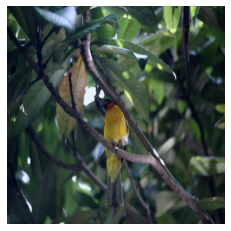

In [ ]:
# ImageNet-1k label mapping file and load it.

mapping_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)

with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image2 = load_image_from_url(img_url, model_type="original_vit")

plt.imshow(image)
plt.axis("off")
plt.show()


In [ ]:
predictions2, attention_score_dict2 = vit_base_i21k_patch16_224.predict(
    preprocessed_image2
)
#attn_rollout_result = attention_rollout_map(image, attention_score_dict, model_type="original_vit")

1/1 [==============================] - 1s 701ms/step


In [ ]:
attn_rollout_result2 = attention_rollout_map(
    image, attention_score_dict2, model_type="original_vit"
)

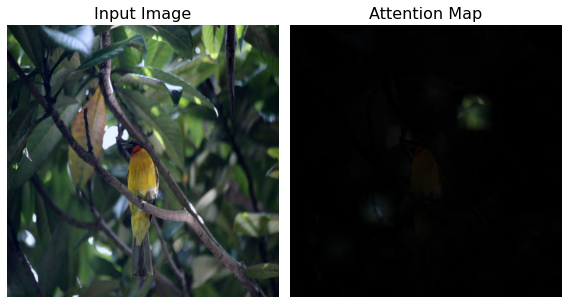

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))

_ = ax1.imshow(image)
_ = ax2.imshow(attn_rollout_result2)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()


Test avec une image de notre dataset

In [ ]:
attn_rollout_result = attention_rollout_map(
    pic, attention_score_dict, model_type="original_vit"
)

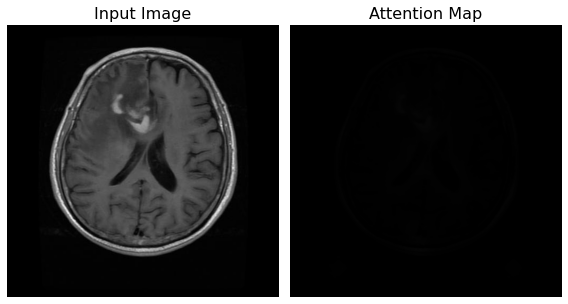

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))

_ = ax1.imshow(pic)
_ = ax2.imshow(attn_rollout_result)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()


#Classification

###Compilation et entraînement du model

Avec seulement deux classes



In [ ]:
#data_dir_cut="/content/drive/MyDrive/Projet_IA_Imagerie/dataset_cut/"
dir_train_cut= "/content/drive/MyDrive/Projet_IA_Imagerie/dataset_cut/Training/"
dir_test_cut = "/content/drive/MyDrive/Projet_IA_Imagerie/dataset_cut/Testing/"


In [ ]:
#data_ds = keras.utils.image_dataset_from_directory(data_dir, batch_size=64, image_size=(224, 224))#training and testing
train_ds_cut = keras.utils.image_dataset_from_directory(dir_train_cut, batch_size=64, image_size=(224, 224))
test_ds_cut = keras.utils.image_dataset_from_directory(dir_test_cut, batch_size=64, image_size=(224, 224))
class_names = train_ds_cut.class_names
print(class_names)

Found 1231 files belonging to 2 classes.
Found 205 files belonging to 2 classes.
['glioma_tumor', 'no_tumor']


In [ ]:
model=vit_base_i21k_patch16_224

In [ ]:
#Compilation
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)



In [ ]:
#Entraînement
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.fit(
    train_ds_cut,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds_cut,
)

#vit_base_i21k_patch16_224.fit(train_ds_cut)

Epoch 1/2


In [ ]:
#Fonction permettant de remplir une liste contenant les map vision rollout transformers
def vit(images):
  images_vit=[]
  for i in images:
    image=PIL.Image.open(str(i))
    preprocessed_image = preprocess_image(image, "original_vit")
    predictions, attention_score_dict = vit_base_i21k_patch16_224.predict(preprocessed_image)
    attn_rollout_result = attention_rollout_map(pic, attention_score_dict, model_type="original_vit")
    images_vit.append(attn_rollout_result)

In [ ]:
#Execution de la fonction
"""glioma_tumor_train_vit = vit(glioma_tumor_train)
glioma_tumor_test_vit = vit(glioma_tumor_test)
no_tumor_train_vit = vit(no_tumor_train)
no_tumor_test_vit = vit(no_tumor_test)"""